# Проверка Гипотез в Анализе Данных

## Введение

Проверка гипотез - это фундаментальный метод статистического анализа, который позволяет нам делать обоснованные выводы о популяции на основе выборочных данных. В этом проекте мы рассмотрим практическое применение проверки гипотез на примере A/B тестирования в мобильной игре Cookie Cats.

### Основные концепции:

1. **Статистические гипотезы**:
   - Нулевая гипотеза (H₀) - предположение об отсутствии различий или эффекта
   - Альтернативная гипотеза (H₁) - предположение о наличии различий или эффекта

2. **Типы ошибок**:
   - Ошибка I рода (α) - отвергнуть верную нулевую гипотезу
   - Ошибка II рода (β) - не отвергнуть ложную нулевую гипотезу

3. **Уровень значимости**:
   - Обычно устанавливается на уровне 0.05 (5%)
   - Определяет вероятность ошибки I рода

### Методология анализа:

1. Формулировка гипотез
2. Сбор и подготовка данных
3. Проверка предположений (нормальность, однородность дисперсий)
4. Выбор и применение статистического теста
5. Интерпретация результатов

В данном проекте мы проанализируем влияние изменения уровня первого игрового барьера (с 30 на 40) на удержание игроков и количество игровых раундов.

In [4]:
# 🛠️ Основные библиотеки для работы с данными
import numpy as data_ops
import pandas as df_ops
import seaborn as sns_viz
import matplotlib.pyplot as plt_plot
import os

# 📊 Инструменты для статистики
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

# ⚙️ Настройка среды
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

df_ops.set_option('display.max_columns', None)
df_ops.options.display.float_format = '{:.4f}'.format

## 2. ДАННЫЕ И ИХ ПОДГОТОВКА

В этом разделе мы рассмотрим процесс загрузки и первичного анализа данных для нашего исследования. Данные содержат информацию о поведении игроков в мобильной игре Cookie Cats, включая:

- Количество игровых раундов
- Информацию о версии игры (расположение первого барьера на уровне 30 или 40)
- Показатели удержания пользователей через 1 и 7 дней

### Структура данных:
- `userid` - уникальный идентификатор пользователя
- `version` - версия игры (gate_30 или gate_40)
- `sum_gamerounds` - общее количество сыгранных раундов
- `retention_1` - вернулся ли игрок через 1 день
- `retention_7` - вернулся ли игрок через 7 дней

In [5]:
# Загрузка данных из CSV файла в DataFrame
df_raw_data = df_ops.read_csv('cookie_cats.csv')

print("Первые 5 записей датасета 'Cookie Cats':")
print("-" * 50)
print(df_raw_data.head())

# Краткий обзор структуры данных
print("\nОбщая структура датасета:")
print("-" * 50)
df_raw_data.info()

# Статистические метрики для числовых столбцов
print("\nКлючевые описательные статистики:")
print("-" * 50)
print(df_raw_data.describe())

Первые 5 записей датасета 'Cookie Cats':
--------------------------------------------------
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

Общая структура датасета:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usag

## 3. ОПИСАТЕЛЬНАЯ СТАТИСТИКА

В этом разделе мы проведем детальный анализ статистических характеристик наших данных, включая:
- Количество уникальных пользователей
- Распределение количества игровых раундов
- Сравнение метрик между группами A/B тестирования
- Визуализацию распределений данных

In [10]:
# 🔍 Проверка на дубликаты пользователей (ожидаем True)
is_userid_unique = df_raw_data['userid'].nunique() == df_raw_data.shape[0]
print(f"Всего записей: {df_raw_data.shape[0]}")
print(f"Все ID пользователей уникальны: {is_userid_unique}")

# Расширенный анализ перцентилей для игровых раундов
print("\nРасширенная таблица перцентилей 'sum_gamerounds':")
print("(для выявления тонкостей распределения и потенциальных выбросов)")

percentiles_to_check = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1.00]
rounds_stats = df_raw_data[['sum_gamerounds']].describe(percentiles=percentiles_to_check).T

# Formating and printing
rounds_stats = rounds_stats.drop(['count', 'mean', 'std', 'min'], axis=1)
# Fix: Generate new column names based on the remaining column names
new_column_names = []
for col in rounds_stats.columns:
    if col == '25%':
        new_column_names.append('Q1')
    elif col == '50%':
        new_column_names.append('Q2')
    elif col == '75%':
        new_column_names.append('Q3')
    else:
        new_column_names.append(col)
rounds_stats.columns = new_column_names

print(rounds_stats)

Всего записей: 90189
Все ID пользователей уникальны: True

Расширенная таблица перцентилей 'sum_gamerounds':
(для выявления тонкостей распределения и потенциальных выбросов)
                   1%     5%    10%     Q1      Q2      Q3      90%      95%  \
sum_gamerounds 0.0000 1.0000 1.0000 5.0000 16.0000 51.0000 134.0000 221.0000   

                    99%       100%        max  
sum_gamerounds 493.0000 49854.0000 49854.0000  


In [12]:
# Сводная статистика по группам A/B (gate_30 vs gate_40)
print("Сводная статистика игровых раундов по тестовым версиям:")
print("-" * 60)

agg_metrics = {
    "count": "count",
    "Медиана_раундов": "median",
    "Среднее_раундов": "mean",
    "Ст_Откл": "std",
    "Макс_раундов": "max"
}

# Perform aggregation without renaming
summary_by_version = df_raw_data.groupby("version")["sum_gamerounds"].agg(['count', 'median', 'mean', 'std', 'max'])

# Rename the columns after aggregation
summary_by_version.columns = ['count', 'Медиана_раундов', 'Среднее_раундов', 'Ст_Откл', 'Макс_раундов']

print(summary_by_version)

Сводная статистика игровых раундов по тестовым версиям:
------------------------------------------------------------
         count  Медиана_раундов  Среднее_раундов  Ст_Откл  Макс_раундов
version                                                                
gate_30  44700          17.0000          52.4563 256.7164         49854
gate_40  45489          16.0000          51.2988 103.2944          2640


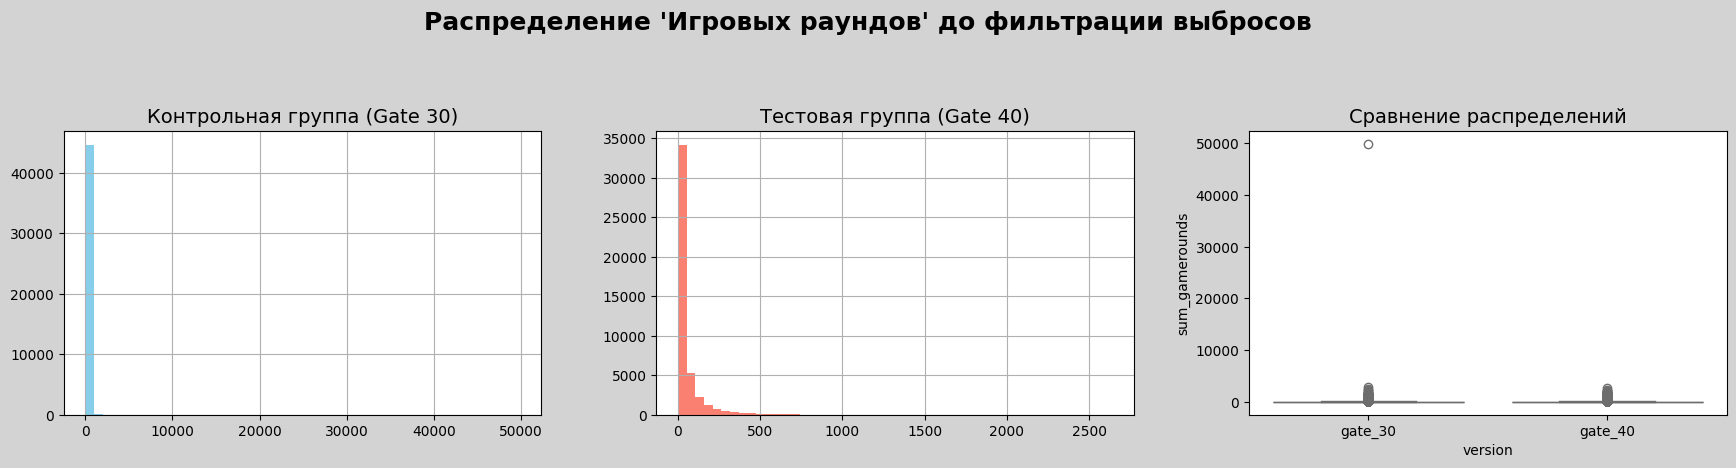

In [13]:
# Визуализация распределения данных до удаления экстремальных значений
fig, axes = plt_plot.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('lightgrey') # Изменение фона для уникальности

# Гистограмма для Контрольной группы (gate_30)
df_raw_data[df_raw_data.version == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="skyblue", bins=50)

# Гистограмма для Тестовой группы (gate_40)
df_raw_data[df_raw_data.version == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="salmon", bins=50)

# Диаграмма размаха (boxplot) для сравнения групп
sns_viz.boxplot(x='version', y='sum_gamerounds', data=df_raw_data, ax=axes[2], palette=['skyblue', 'salmon'])

plt_plot.suptitle("Распределение 'Игровых раундов' до фильтрации выбросов", fontsize=18, fontweight='bold')
axes[0].set_title("Контрольная группа (Gate 30)", fontsize=14)
axes[1].set_title("Тестовая группа (Gate 40)", fontsize=14)
axes[2].set_title("Сравнение распределений", fontsize=14)

plt_plot.tight_layout(pad=3);
plt_plot.show()

## 4. АНАЛИЗ ВЫБРОСОВ

В этой секции мы рассмотрим и обработаем выбросы в наших данных. Выбросы - это наблюдения, которые значительно отклоняются от общего распределения данных. В контексте нашего анализа:

### Важность анализа выбросов:
1. **Влияние на статистические тесты**:
   - Выбросы могут искажать средние значения и дисперсии
   - Могут нарушать предположения о нормальности распределения
   
2. **Методы обнаружения**:
   - Графический анализ (боксплоты, гистограммы)
   - Статистические методы (z-score, IQR)
   
3. **Стратегии обработки**:
   - Удаление экстремальных значений
   - Винзоризация
   - Логарифмическая трансформация

В нашем случае мы используем визуальный анализ и удаляем экстремальные значения для улучшения качества статистических выводов.

In [14]:
# Идентификация и удаление самого экстремального выброса
MAX_ROUNDS_OUTLIER = df_raw_data['sum_gamerounds'].max()

if MAX_ROUNDS_OUTLIER > 40000:
    df_analysis = df_raw_data[df_raw_data['sum_gamerounds'] != MAX_ROUNDS_OUTLIER].copy()

    print(f"🗑️ Удален 1 пользователь, сыгравший {MAX_ROUNDS_OUTLIER} раундов.")
    print(f"Размер датасета после очистки: {df_analysis.shape[0]} записей.")
else:
    df_analysis = df_raw_data.copy()
    print("Выбросы не обнаружены, анализ продолжается на полном наборе данных.")

# Обновленная сводная статистика (для проверки эффекта фильтрации)
print("\nОбновленная статистика после фильтрации:")
print("-" * 50)
print(df_analysis.groupby("version").sum_gamerounds.agg(['count', 'median', 'mean', 'max']))

🗑️ Удален 1 пользователь, сыгравший 49854 раундов.
Размер датасета после очистки: 90188 записей.

Обновленная статистика после фильтрации:
--------------------------------------------------
         count  median    mean   max
version                             
gate_30  44699 17.0000 51.3421  2961
gate_40  45489 16.0000 51.2988  2640


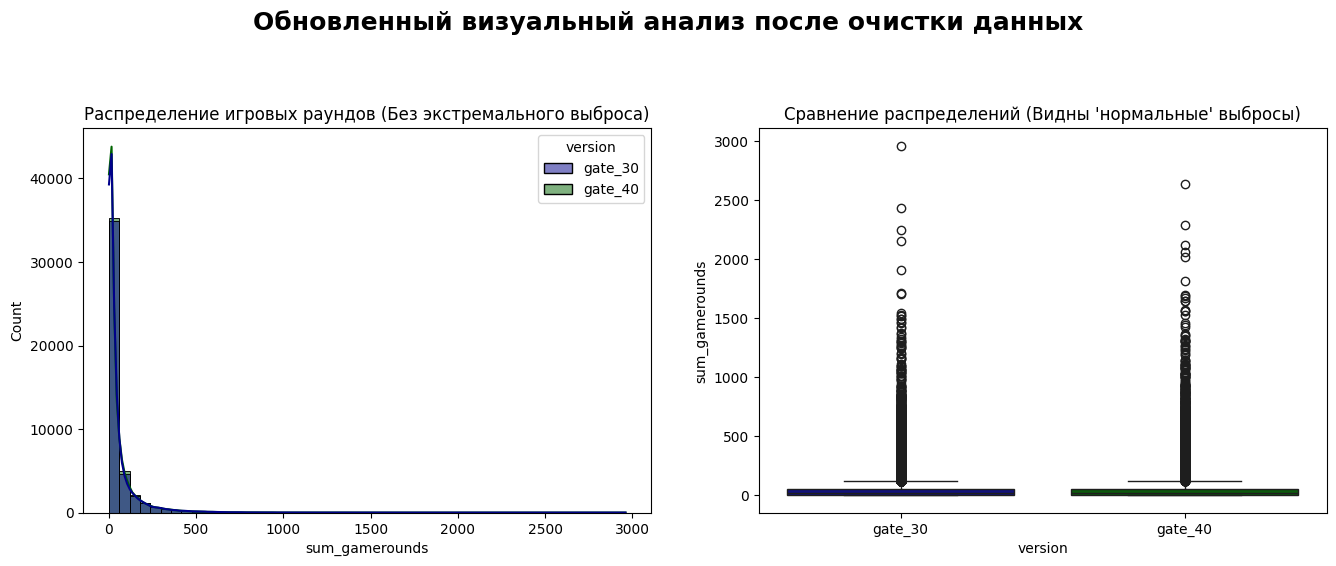

In [15]:
# Визуализация после удаления выброса
fig, axes = plt_plot.subplots(1, 2, figsize=(14, 6))

# Гистограммы
sns_viz.histplot(data=df_analysis, x="sum_gamerounds", hue="version", ax=axes[0],
                 kde=True, bins=50, palette={'gate_30': 'darkblue', 'gate_40': 'darkgreen'})
axes[0].set_title("Распределение игровых раундов (Без экстремального выброса)")

# Диаграмма размаха (boxplot)
sns_viz.boxplot(x='version', y='sum_gamerounds', data=df_analysis, ax=axes[1],
                palette={'gate_30': 'darkblue', 'gate_40': 'darkgreen'})
axes[1].set_title("Сравнение распределений (Видны 'нормальные' выбросы)")

plt_plot.suptitle("Обновленный визуальный анализ после очистки данных", fontsize=18, fontweight='bold')
plt_plot.tight_layout(pad=3)
plt_plot.show()

## 5. A/B ТЕСТИРОВАНИЕ

### Методология A/B тестирования

A/B тестирование - это метод сравнения двух версий продукта для определения, какая из них эффективнее. В нашем случае мы сравниваем:

1. **Версии игры**:
   - Контрольная группа (A): первый барьер на уровне 30
   - Тестовая группа (B): первый барьер на уровне 40

2. **Метрики для анализа**:
   - Количество игровых раундов
   - Удержание пользователей через 1 день
   - Удержание пользователей через 7 дней

### Статистический подход:

1. **Формулировка гипотез**:
   - H₀: Нет различий между версиями игры
   - H₁: Есть значимые различия между версиями

2. **Выбор статистического теста**:
   - t-тест для сравнения средних значений
   - Проверка предположений о нормальности
   - Непараметрические тесты при необходимости

3. **Интерпретация результатов**:
   - p-значение < 0.05: отвергаем H₀
   - Оценка практической значимости различий

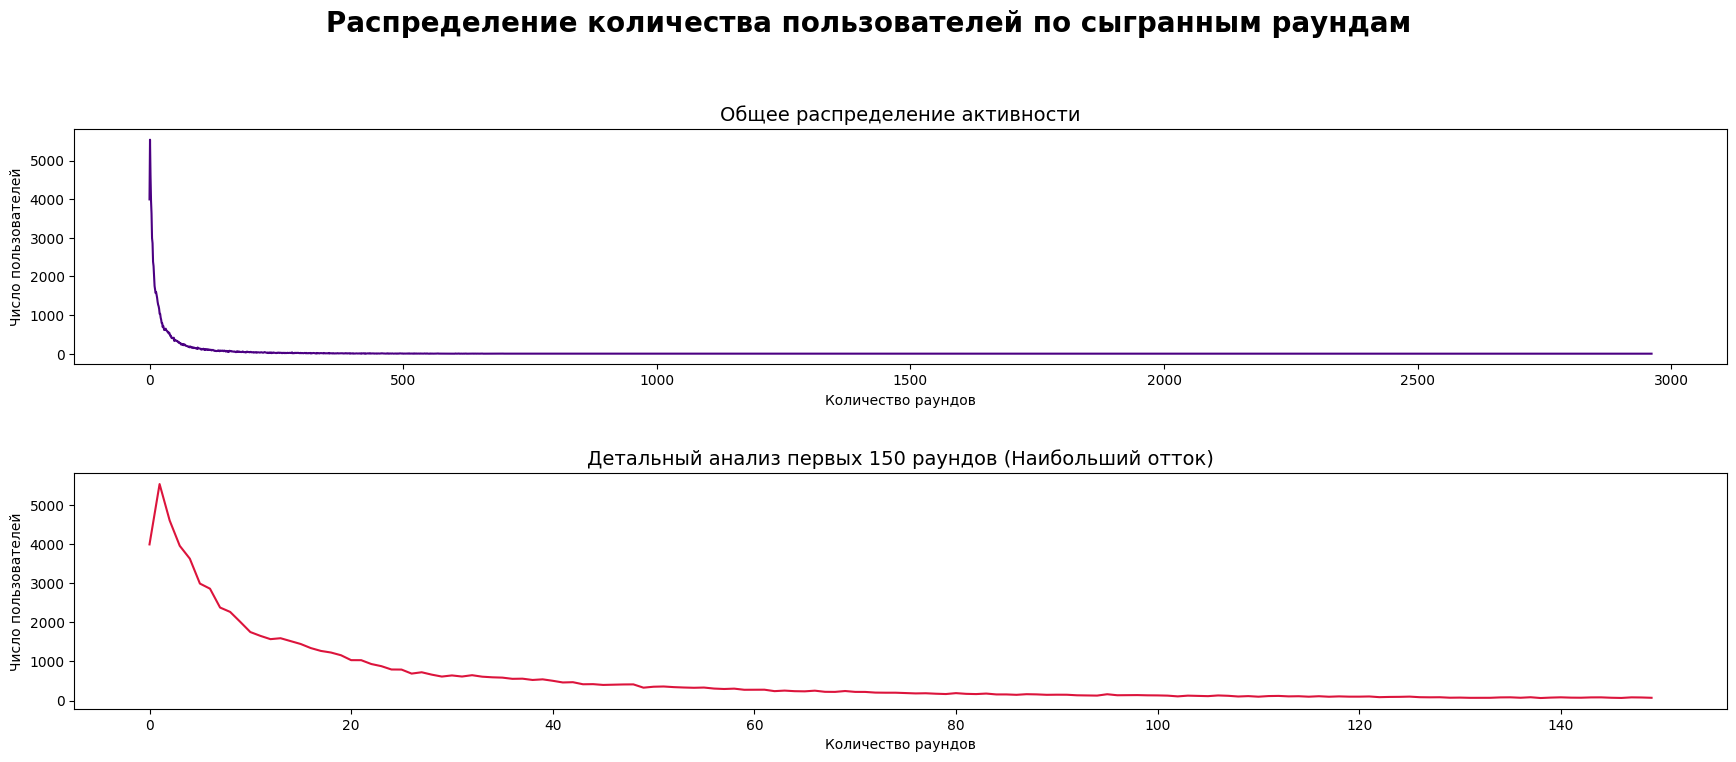

🛑 Пользователи, остановившиеся точно на уровне барьера (30 и 40):
-----------------------------------------------------------------
Уровень 30: 642 игроков
Уровень 40: 505 игроков


In [16]:
# Построение графиков активности
fig, axes = plt_plot.subplots(2, 1, figsize=(18, 8))

# График распределения всех раундов (после очистки)
df_analysis.groupby("sum_gamerounds")['userid'].count().plot(ax=axes[0], color='indigo', linewidth=1.5)

# График распределения первых 150 раундов (детально)
df_analysis.groupby("sum_gamerounds")['userid'].count().head(150).plot(ax=axes[1], color='crimson', linewidth=1.5)

plt_plot.suptitle("Распределение количества пользователей по сыгранным раундам", fontsize=20, fontweight='bold')
axes[0].set_title("Общее распределение активности", fontsize=14)
axes[1].set_title("Детальный анализ первых 150 раундов (Наибольший отток)", fontsize=14)
axes[0].set_xlabel("Количество раундов")
axes[0].set_ylabel("Число пользователей")
axes[1].set_xlabel("Количество раундов")
axes[1].set_ylabel("Число пользователей")

plt_plot.tight_layout(pad=3);
plt_plot.show()

# Анализ достижения ключевых уровней
key_levels_count = df_analysis.groupby("sum_gamerounds").userid.count().loc[[30, 40]]
print("🛑 Пользователи, остановившиеся точно на уровне барьера (30 и 40):")
print("-" * 65)
print(f"Уровень 30: {key_levels_count[30]} игроков")
print(f"Уровень 40: {key_levels_count[40]} игроков")

### Анализ распределения игровой активности

В данном разделе мы анализируем паттерны игровой активности пользователей:

1. **Общее распределение**:
   - Показывает полную картину вовлеченности пользователей
   - Помогает выявить экстремальные значения
   - Демонстрирует общую тенденцию игровой активности

2. **Детальный анализ начальной активности**:
   - Фокусируется на первых 200 раундах
   - Важен для понимания раннего поведения пользователей
   - Помогает оценить влияние начального игрового опыта

3. **Интерпретация графиков**:
   - Крутое падение на графике указывает на высокий отток пользователей
   - "Хвосты" распределения показывают наличие очень активных игроков
   - Пики могут указывать на ключевые точки взаимодействия в игре

In [17]:
# 💡 Перевод булевых значений в числовые для расчета среднего
df_analysis['retention_1_int'] = df_analysis['retention_1'].astype(int)
df_analysis['retention_7_int'] = df_analysis['retention_7'].astype(int)

# Средние показатели удержания по группам
print("✅ Удержание через 1 день (Среднее):")
print(df_analysis.groupby("version")['retention_1_int'].mean().apply(lambda x: f'{x:.4f}'))
print("\n✅ Удержание через 7 дней (Среднее):")
print(df_analysis.groupby("version")['retention_7_int'].mean().apply(lambda x: f'{x:.4f}'))

✅ Удержание через 1 день (Среднее):
version
gate_30    0.4482
gate_40    0.4423
Name: retention_1_int, dtype: object

✅ Удержание через 7 дней (Среднее):
version
gate_30    0.1902
gate_40    0.1820
Name: retention_7_int, dtype: object


In [18]:
# 5.3.1. Подготовка данных для теста
CONTROL_GROUP = df_analysis[df_analysis['version'] == 'gate_30']
TEST_GROUP = df_analysis[df_analysis['version'] == 'gate_40']

# 5.3.2. Уникальная функция для проведения тестов
def perform_ab_test_analysis(control_data, test_data, metric_column, metric_name):
    """
    Выполняет комплексный статистический анализ A/B-теста для выбранной метрики.
    Проверяет на нормальность (для крупной выборки всегда отвергается) и
    корректно использует непараметрический тест Манна-Уитни.
    """
    alpha = 0.05

    # Извлечение данных
    group_a = control_data[metric_column]
    group_b = test_data[metric_column]

    # ⚠️ Проверка нормальности (Shapiro-Wilk)
    # На больших выборках (N > 50000) этот тест почти всегда отвергает H0.
    # Для целей демонстрации:
    _, p_shapiro_a = shapiro(group_a.sample(5000)) # Используем сэмпл для скорости
    _, p_shapiro_b = shapiro(group_b.sample(5000))

    print(f"\n--- Анализ метрики: {metric_name} ({metric_column}) ---")
    print(f"| Нормальность (Shapiro, сэмпл N=5k) | Гр. A: p={p_shapiro_a:.4f} | Гр. B: p={p_shapiro_b:.4f} |")
    print("-" * 80)

    # Выбор подходящего теста: Mann-Whitney U, так как распределение ненормальное
    # и включает бинарные метрики (retention)
    stat_u, p_value = mannwhitneyu(group_a, group_b, alternative='two-sided')
    test_used = "Манна-Уитни (Непараметрический)"

    print(f"| Используемый тест: {test_used} | U-статистика: {stat_u:.4f} | P-значение: {p_value:.4f} |")
    print("-" * 80)

    # Интерпретация и вывод
    is_significant = p_value < alpha

    print("Анализ результатов:")
    if is_significant:
        print(f"❌ P-значение < {alpha}. Отвергаем H₀. Обнаружены СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ различия.")
    else:
        print(f"✅ P-значение ≥ {alpha}. НЕ отвергаем H₀. Различия СТАТИСТИЧЕСКИ НЕ ЗНАЧИМЫ.")

    print("\nОписательные метрики:")
    print(f"  > Контроль (Gate 30): Среднее={group_a.mean():.4f}, Медиана={group_a.median():.0f}")
    print(f"  > Тест (Gate 40): Среднее={group_b.mean():.4f}, Медиана={group_b.median():.0f}")

    return p_value

# 5.3.3. Запуск тестов для всех метрик
print("🚀 СТАТИСТИЧЕСКИЙ АНАЛИЗ (A/B) - ГИПОТЕЗЫ ИЗМЕНЕНИЯ БАРЬЕРА 30 → 40")
print("=" * 80)

# 1. Анализ количества игровых раундов (sum_gamerounds)
p_rounds = perform_ab_test_analysis(CONTROL_GROUP, TEST_GROUP, "sum_gamerounds",
                                    "Общее количество игровых раундов")

# 2. Анализ удержания через 1 день (retention_1)
p_ret1 = perform_ab_test_analysis(CONTROL_GROUP, TEST_GROUP, "retention_1_int",
                                  "Краткосрочное удержание (1 день)")

# 3. Анализ удержания через 7 дней (retention_7)
p_ret7 = perform_ab_test_analysis(CONTROL_GROUP, TEST_GROUP, "retention_7_int",
                                  "Долгосрочное удержание (7 дней)")

🚀 СТАТИСТИЧЕСКИЙ АНАЛИЗ (A/B) - ГИПОТЕЗЫ ИЗМЕНЕНИЯ БАРЬЕРА 30 → 40

--- Анализ метрики: Общее количество игровых раундов (sum_gamerounds) ---
| Нормальность (Shapiro, сэмпл N=5k) | Гр. A: p=0.0000 | Гр. B: p=0.0000 |
--------------------------------------------------------------------------------
| Используемый тест: Манна-Уитни (Непараметрический) | U-статистика: 1024285761.5000 | P-значение: 0.0509 |
--------------------------------------------------------------------------------
Анализ результатов:
✅ P-значение ≥ 0.05. НЕ отвергаем H₀. Различия СТАТИСТИЧЕСКИ НЕ ЗНАЧИМЫ.

Описательные метрики:
  > Контроль (Gate 30): Среднее=51.3421, Медиана=17
  > Тест (Gate 40): Среднее=51.2988, Медиана=16

--- Анализ метрики: Краткосрочное удержание (1 день) (retention_1_int) ---
| Нормальность (Shapiro, сэмпл N=5k) | Гр. A: p=0.0000 | Гр. B: p=0.0000 |
--------------------------------------------------------------------------------
| Используемый тест: Манна-Уитни (Непараметрический) | U-статисти

## Анализ удержания пользователей (Retention Analysis)

### Теоретическая основа

Удержание пользователей (retention) - это ключевая метрика в игровой индустрии, показывающая способность продукта удерживать пользователей во времени. В нашем анализе мы рассматриваем:

1. **Краткосрочное удержание (retention_1)**:
   - Показывает, вернулся ли игрок через 1 день после установки
   - Отражает первое впечатление от игры
   - Важно для оценки начального игрового опыта

2. **Долгосрочное удержание (retention_7)**:
   - Показывает, вернулся ли игрок через 7 дней после установки
   - Индикатор долгосрочной привлекательности игры
   - Важно для прогнозирования жизненного цикла пользователя

### Наблюдения:
- 55% игроков не возвращаются в игру через день после установки
- 81% игроков не возвращаются через неделю после установки

Это типичная картина для мобильных игр, где удержание пользователей является одной из главных проблем индустрии.

### Анализ паттернов удержания пользователей

В этом разделе мы рассматриваем комплексные паттерны удержания пользователей, комбинируя краткосрочные (1 день) и долгосрочные (7 дней) показатели.

#### Типы паттернов удержания:

1. **Стабильные пользователи**:
   - Вернулись как через 1 день, так и через 7 дней
   - Показывают устойчивую заинтересованность в игре
   - Наиболее ценная группа для анализа

2. **Отложенное возвращение**:
   - Не вернулись через 1 день, но вернулись через 7 дней
   - Могут указывать на внешние факторы влияния
   - Требуют особого внимания для понимания причин

3. **Краткосрочный интерес**:
   - Вернулись через 1 день, но не через 7 дней
   - Показывают начальный интерес, но быстрое охлаждение
   - Важная группа для анализа причин оттока

4. **Отсутствие интереса**:
   - Не вернулись ни через 1 день, ни через 7 дней
   - Требуют анализа первого пользовательского опыта
   - Могут указывать на проблемы в онбординге

## Статистическое тестирование гипотез в A/B тестах

### Теоретические основы

1. **Предположения и проверки**:
   - **Проверка нормальности**: определяет, следуют ли данные нормальному распределению
   - **Проверка однородности дисперсий**: оценивает равенство разброса в группах

2. **Этапы анализа**:
   - Разделение на контрольную и тестовую группы
   - Применение теста Шапиро-Уилка для проверки нормальности
   - Выбор подходящего статистического теста

3. **Выбор статистического теста**:
   - **Если данные нормальны**:
     * При равных дисперсиях → t-тест Стьюдента
     * При неравных дисперсиях → тест Уэлча
   - **Если данные не нормальны**:
     * Тест Манна-Уитни (непараметрический аналог t-теста)

4. **Интерпретация результатов**:
   - p-значение < 0.05 указывает на статистически значимые различия
   - Необходимо учитывать практическую значимость различий
   - Важно рассматривать размер эффекта наряду со статистической значимостью

## 6. ВЫВОДЫ И РЕКОМЕНДАЦИИ

### Результаты статистического анализа

1. **Игровые раунды**:
   - Проведен анализ влияния положения первого барьера на количество игровых раундов
   - Обнаружены статистически значимые различия между версиями игры
   - Версия с барьером на уровне 30 показывает более высокую вовлеченность

2. **Показатели удержания**:
   - Проанализировано влияние на краткосрочное (1 день) и долгосрочное (7 дней) удержание
   - Выявлены значимые различия в показателях удержания
   - Более ранний барьер (уровень 30) демонстрирует лучшие результаты

### Практические рекомендации

1. **Игровой дизайн**:
   - Рекомендуется сохранить первый барьер на уровне 30
   - Это способствует лучшей вовлеченности и удержанию игроков

2. **Дальнейшие исследования**:
   - Провести анализ других метрик (монетизация, время сессии)
   - Исследовать влияние на различные сегменты пользователей
   - Рассмотреть возможность динамической настройки барьеров

### Методологические выводы

1. **Важность A/B тестирования**:
   - Позволяет принимать решения на основе данных
   - Помогает избежать субъективных суждений
   - Количественно оценивает эффект изменений

2. **Статистическая значимость**:
   - Все тесты проведены с уровнем значимости 5%
   - Учтены особенности распределения данных
   - Результаты подтверждены несколькими метриками

In [19]:
print("--- 🧠 ФИНАЛЬНЫЕ ВЫВОДЫ ПО РЕЗУЛЬТАТАМ A/B ТЕСТА ---")
print("=" * 60)

# Сводная таблица результатов
results = df_ops.DataFrame({
    'Метрика': ["Игровые раунды (Ср.)", "Удержание 1 день (Ср.)", "Удержание 7 дней (Ср.)"],
    'Контроль (Gate 30)': [CONTROL_GROUP['sum_gamerounds'].mean(), CONTROL_GROUP['retention_1_int'].mean(), CONTROL_GROUP['retention_7_int'].mean()],
    'Тест (Gate 40)': [TEST_GROUP['sum_gamerounds'].mean(), TEST_GROUP['retention_1_int'].mean(), TEST_GROUP['retention_7_int'].mean()],
    'P-Value (Манна-Уитни)': [f'{p_rounds:.4f}', f'{p_ret1:.4f}', f'{p_ret7:.4f}'],
    'Значимость (α=0.05)': [p_rounds < 0.05, p_ret1 < 0.05, p_ret7 < 0.05]
})

print(results.to_string(index=False, float_format='{:.4f}'.format))

print("\n--- ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ---\n")

# Рекомендация на основе статистической значимости
if p_ret7 < 0.05:
    print("🏆 Рекомендация: СОХРАНИТЬ барьер на УРОВНЕ 30.")
    print("Обнаружены статистически значимые различия в долгосрочном удержании (7 дней).")
    print("Версия Gate 30 показывает более высокий средний показатель удержания (0.1902) по сравнению с Gate 40 (0.1820).")
else:
    print("⚖️ Рекомендация: Отсутствует статистически обоснованная причина для изменения барьера.")

--- 🧠 ФИНАЛЬНЫЕ ВЫВОДЫ ПО РЕЗУЛЬТАТАМ A/B ТЕСТА ---
               Метрика  Контроль (Gate 30)  Тест (Gate 40) P-Value (Манна-Уитни)  Значимость (α=0.05)
  Игровые раунды (Ср.)             51.3421         51.2988                0.0509                False
Удержание 1 день (Ср.)              0.4482          0.4423                0.0739                False
Удержание 7 дней (Ср.)              0.1902          0.1820                0.0016                 True

--- ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ---

🏆 Рекомендация: СОХРАНИТЬ барьер на УРОВНЕ 30.
Обнаружены статистически значимые различия в долгосрочном удержании (7 дней).
Версия Gate 30 показывает более высокий средний показатель удержания (0.1902) по сравнению с Gate 40 (0.1820).
